In [56]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.stats as ss
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
import time

Load the latent space data

In [57]:
compressed = np.load("../MNIST_project/output/compressed_output/compressed.npz")
names = compressed["names"]
data = compressed["data"]
print(f"Latent space shape: {data.shape}")

zeros = np.where(names == 0)[0]
ones = np.where(names == 1)[0]
twos = np.where(names == 2)[0]
threes = np.where(names == 3)[0]
fours = np.where(names == 4)[0]
fives = np.where(names == 5)[0]
sixes = np.where(names == 6)[0]
sevens = np.where(names == 7)[0]
eights = np.where(names == 8)[0]
nines = np.where(names == 9)[0]

numbers = [
    [zeros, "zero"],
    [ones, "one"],
    [twos, "two"],
    [threes, "three"],
    [fours, "four"],
    [fives, "five"],
    [sixes, "six"],
    [sevens, "seven"],
    [eights, "eight"],
    [nines, "nine"],
]


Latent space shape: (70000, 79)


Change the dimensions from data.shape[1] (currently 79) to 2 using PCA

In [58]:
pca = PCA(n_components=2)
start = time.time()
latent_2d_pca = pca.fit_transform(data)


Plot the results for each digit

Text(0.5, 0.98, 'PCA dimensionality reduction from 79 features -> 2 features\nModel: AE, Epochs: 80, Batch Size: 512')

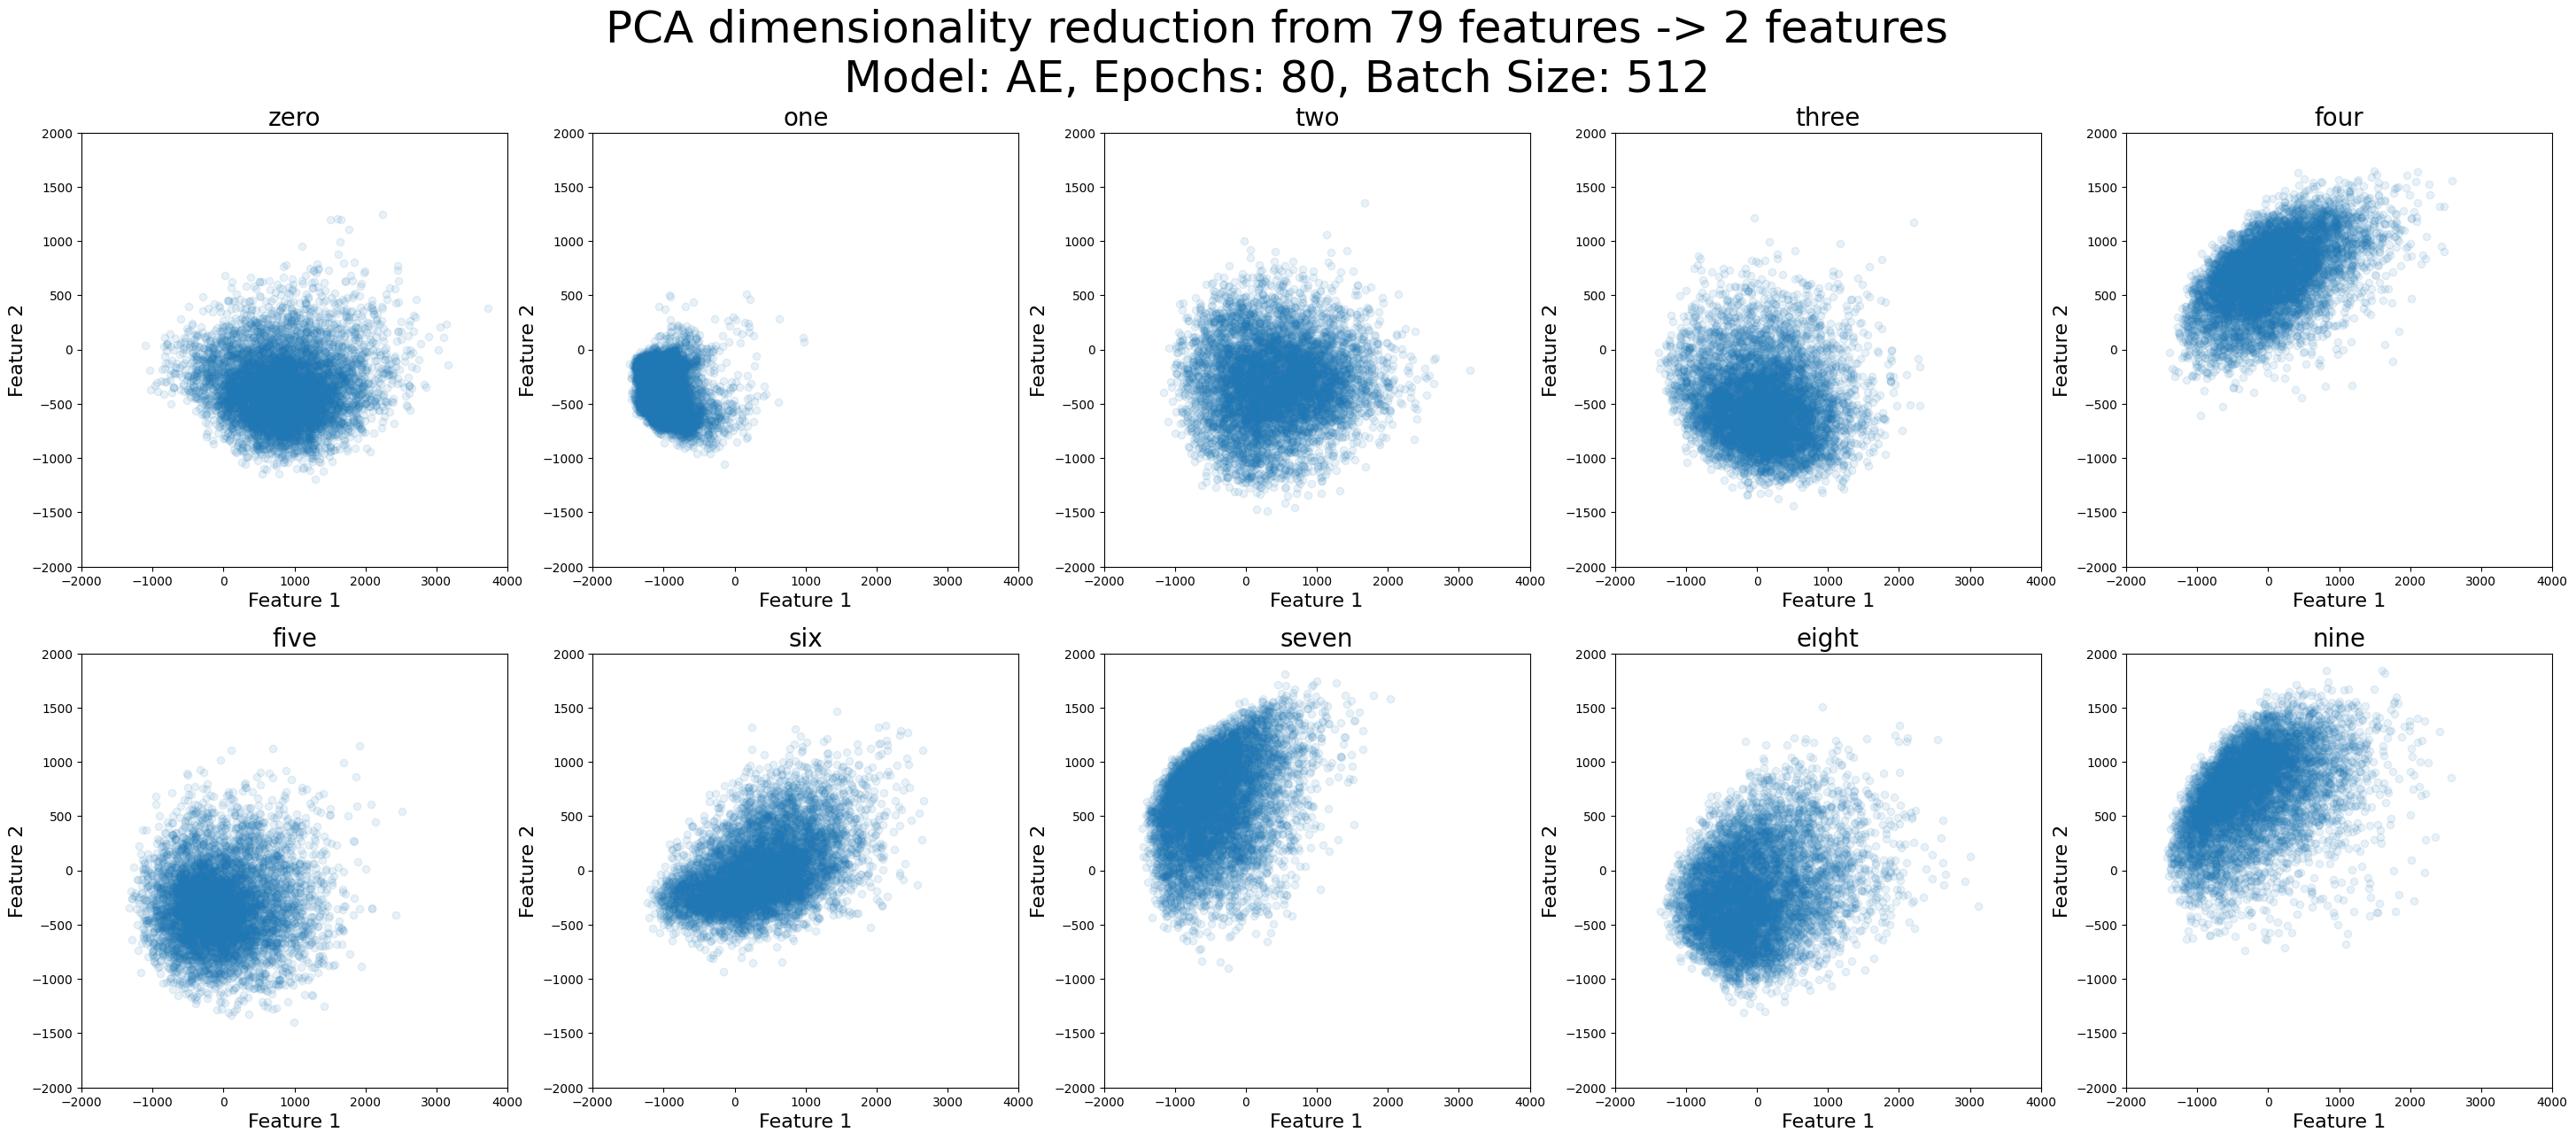

In [59]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(36, 14))

x_min = 0
x_max = 0
y_min = 0
y_max = 0

for number, ax in zip(numbers, axs.flatten()):
    ax.scatter(latent_2d_pca[:,0][number[0]], latent_2d_pca[:,1][number[0]], alpha=0.1)
    ax.set_title(number[1], fontsize=20)
    if (maxi := max(ax.get_xticks())) > x_max:
        x_max = maxi
    if (mini := min(ax.get_xticks())) < x_min:
        x_min = mini
    if (maxi := max(ax.get_yticks())) > y_max:
        y_max = maxi
    if (mini := min(ax.get_yticks())) < y_min:
        y_min = mini
    ax.set_xlabel("Feature 1", fontsize=16)
    ax.set_ylabel("Feature 2", fontsize=16)

    
for ax in axs.flatten():
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
fig.suptitle(f"PCA dimensionality reduction from {data.shape[1]} features -> 2 features\nModel: AE, Epochs: 80, Batch Size: 512", fontsize=36)
# plt.savefig("latent_space_2_features_plot.png", dpi=600)

Finding the images which are the furthest distance from the mean, both as worst 5%, or more than 2 standard deviations away

In [80]:
means = []
covs = []
good = 0
bad = 0
min_idxs = []
max_idxs = []
furthest_indices = []
furthest_std_indices= []
for count1, number in enumerate(numbers):
    mean = np.mean(data[number[0]], axis=0)
    cov = np.cov(data[number[0]], rowvar=0)
    means.append(mean)
    covs.append(cov)

    distances = np.linalg.norm(data[number[0]] - mean, axis=1)
    new_dists = []
    for img in data[number[0]]:
        new_dists.append(np.sqrt(np.sum((img - mean)**2)))
    print(np.all(distances == new_dists))
    cutoff_index = int(len(distances) * 0.01)
    cutoff_distance = np.partition(distances, -cutoff_index)[-cutoff_index]
    furthest_indices.append(number[0][distances >= cutoff_distance])

    std_distance = np.linalg.norm(np.sqrt(np.diag(cov)))
    furthest_std_indices.append(number[0][distances >= 2*std_distance])

furthest_indices = np.concatenate(furthest_indices)
furthest_std_indices = np.concatenate(furthest_std_indices)

print(f"1% is {len(furthest_indices)}/{len(data)}")
print(f"2 std is {len(furthest_std_indices)}/{len(data)}")


True
True
True
True
True
True
True
True
True
True
1% is 695/70000
2 std is 96/70000


Comparing these results to fitting a multivariate gaussian using sklearn

In [69]:
import time

ITERATIONS = 32

sklearn_means = []
sklearn_covs = []

for number in numbers:
    gmm = GaussianMixture(n_components=1, covariance_type='full')
    gmm.fit(data[number[0]])

    mean = gmm.means_[0]
    covariance = gmm.covariances_[0]
    sklearn_means.append(mean)
    sklearn_covs.append(covariance)

print("digit    mean difference     cov difference")
for count, (mean, sk_mean, cov, sk_cov) in enumerate(zip(means, sklearn_means, covs, sklearn_covs)):
    print(f"{count}        {np.sqrt(np.sum((mean-sk_mean)**2)):.5f}                {np.sqrt(np.sum((np.sqrt(np.diag(cov))-np.sqrt(np.diag(sk_cov)))**2)):.5f}")


digit    mean difference     cov difference
0        0.00329                0.11513
1        0.00241                0.06709
2        0.00350                0.11958
3        0.00325                0.10934
4        0.00295                0.10824
5        0.00228                0.12741
6        0.00419                0.11255
7        0.00291                0.09776
8        0.00321                0.11798
9        0.00338                0.10299


Plot a random sample of five of the outliers

=== Plotting index:30054 digit: 2 ===
=== Plotting index:62293 digit: 9 ===
=== Plotting index:21576 digit: 0 ===
=== Plotting index:22188 digit: 2 ===
=== Plotting index:54024 digit: 5 ===


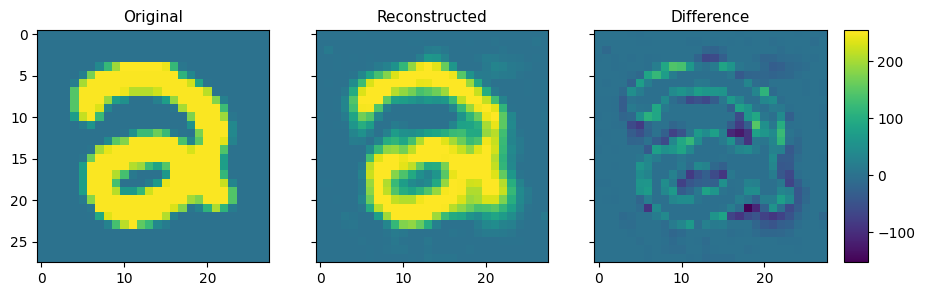

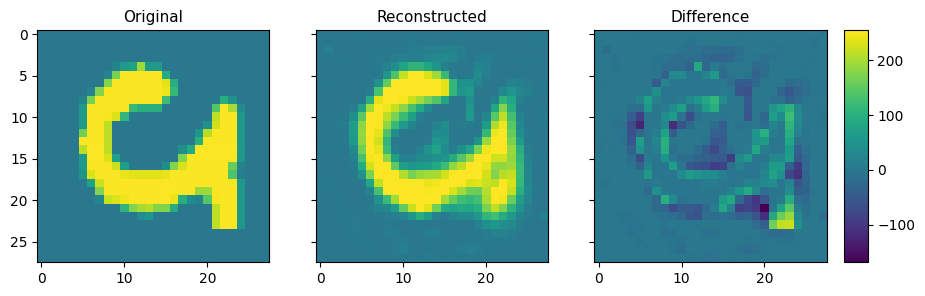

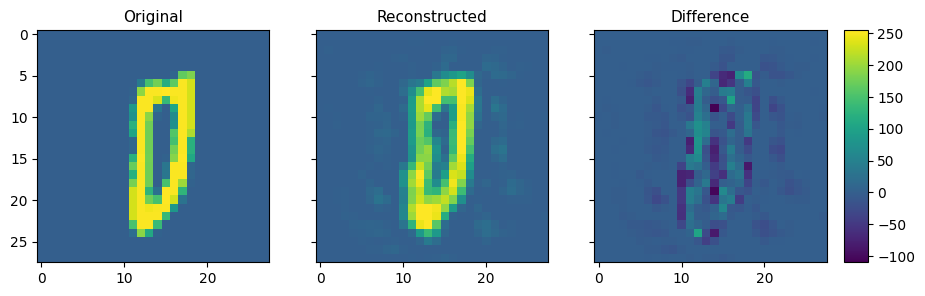

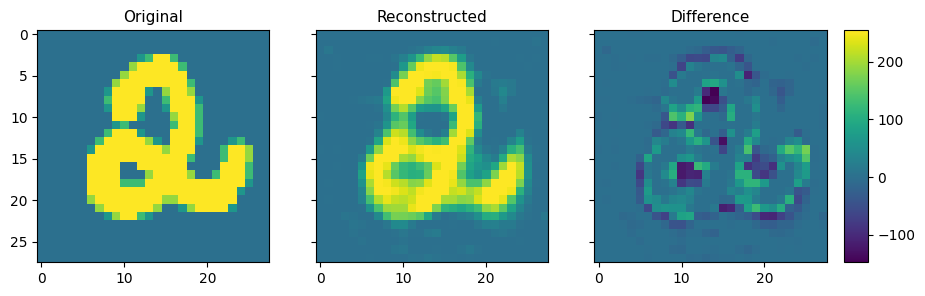

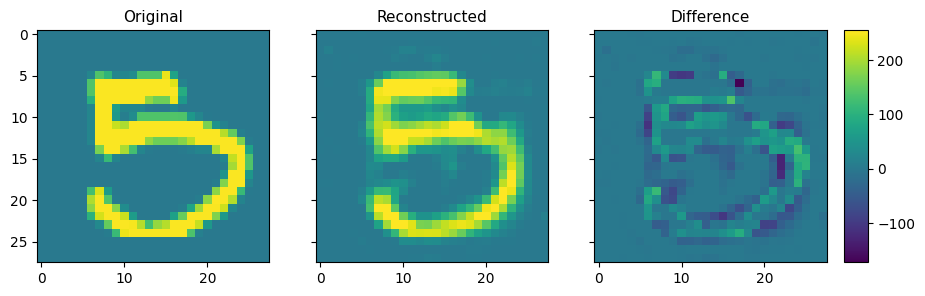

In [68]:
orig_file = np.load("/gluster/home/ofrebato/baler/workspaces/MNIST/data/mnist_combined.npz")
decomp_file = np.load(
    "/gluster/home/ofrebato/baler/workspaces/MNIST/MNIST_project/output/decompressed_output/decompressed.npz"
)

if not np.all(orig_file["names"] == decomp_file["names"]):
    orig_file = np.load("/gluster/home/ofrebato/baler/workspaces/MNIST/data/mnist_combined_outlier_order.npz")
    print("Outlier order")

orig_data = orig_file["data"].astype(np.float32)
decomp_data = decomp_file["data"].astype(np.float32)
names = orig_file["names"][: len(decomp_data)]

for idx in np.random.choice(furthest_indices, size=5):
    print(f"=== Plotting index:{idx} digit: {names[idx]} ===")

    tile_data = orig_data[idx].astype(np.float32)
    tile_data_decompressed = decomp_data[idx].astype(np.float32)

    diff = tile_data - tile_data_decompressed

    max_value = np.amax([np.amax(tile_data), np.amax(tile_data_decompressed), np.amax(diff)])
    min_value = np.amin([np.amin(tile_data), np.amin(tile_data_decompressed), np.amin(diff)])


    fig, axs = plt.subplots(1, 3, figsize=(29.7 * (1 / 2.54), 10 * (1 / 2.54)), sharey=True)
    axs[0].set_title("Original", fontsize=11)
    im1 = axs[0].imshow(tile_data, vmax=max_value, vmin=min_value)
    axs[1].set_title("Reconstructed", fontsize=11)
    im2 = axs[1].imshow(tile_data_decompressed, vmax=max_value, vmin=min_value)
    axs[2].set_title("Difference", fontsize=11)
    im3 = axs[2].imshow(diff, vmax=max_value, vmin=min_value)

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.815, 0.2, 0.02, 0.59])
    cb2 = fig.colorbar(im3, cax=cbar_ax, location="right", aspect=10)
    # plt.savefig(f"/gluster/home/ofrebato/baler/workspaces/MNIST/testing/latent_closest/closest_{names[idx]}.png", dpi=600)
